In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import matplotlib.colors as colors
import numpy as np
from scipy.optimize import nnls
import matplotlib.patches as mpatches

# Smarter model, paper model

In [2]:
def normalize_model1(df):
    percentages=independent_variables=["ProbabilityScalarArithmetic",
                       "ProbabilityScalarLogic", 	"ProbabilityScalarMemory",
                       "ProbabilityScalarBranch", 	"ProbabilityScalarJump",
                       "ProbabilityVectorArithmetic", 	"ProbabilityVectorLogic",
                       "ProbabilityVectorMemory", 	"ProbabilityVectorBranch",
                       "ProbabilityVectorJump"]
    
    df[percentages]=df[percentages]/100
    Pidle = 351
    df["SystemCpuUsage"]=df["SystemCpuUsage"]*128/100
    df["ProcessCpuUsage"]=df["ProcessCpuUsage"]*128/100
    df["Total_power"]=df["PSUPower0"]+df["PSUPower1"] 
    df["Total_socket"]=df["SocketPower0"]+df["SocketPower1"] 
    TDP=280

    for var in independent_variables:
  #      df[var]=df[var]*df["SystemCpuUsage"]*TDP*2
        df[var]=np.log(df[var]*df["SystemCpuUsage"] + 1)#*df["Total_socket"]
        
    df = df[ (df["SocketPower0"] > 0) & (df["SocketPower1"] > 0) ]
        
    return df


In [3]:
def load_df_list_train():
    directory_list=["results_1500/results_32","results_1500/results_64",
                    "results_1500/results_96","results_1500/results_16","results_1500/results_48","results_1500/results_80",
                    "results_1500/results_112","results_1500/results_dgemm",
                    "results_1500/results_128","results_1500/results_sleep","results_1500/results_fan"]

    #directory_list=["results_1500/results_32"]
    df_list=list()
    for directory in directory_list:
        for filename in os.listdir(directory):
            if filename.endswith(".csv"):
                try:
                    df = pd.read_csv(os.path.join(directory, filename))
                    
                    if ("dgemm" not in directory) and ("simple" not in directory) and ("sleep" not in directory)and ("fan" not in directory) and (filename.find("_") > 0) and (filename.find(".") > 0):
                        bench_name=filename[filename.find("_")+1:filename.find(".")]
                    elif "dgemm" in directory:
                        bench_name="dgemm"
                    elif "simple" in directory:
                        bench_name="simple"
                    elif "sleep" in directory:
                        bench_name="sleep"
                    
                    if "sleep" in directory:
                        cores=0
                    elif "fan" in directory:
                        cores=1
                    elif "dgemm" in directory:
                        cores=int(filename[6:filename.find(".")])
                    elif "simple" in directory:
                        cores=int(filename[6:filename.find(".")])
                    else:
                        cores=int(directory.split("_")[2])
                    #df["name"]=directory+filename[]
                    df["name"]=bench_name
                    df["cores"]=cores
                    #df_list.append(df)
                    df_list.append(df.iloc[10:30])
                    #print(type(df_list[-1]))
                    #print(f"Opened file: {filename}")
                    #print(df.head())  # prints the first 5 rows of each CSV file
                    #plot(df,os.path.basename(filename).split(".")[0])
                except Exception as e:
                    print(e)
    return df_list
    
def load_df_list_test():
    directory_list=["results_1500/results_32","results_1500/results_64",
                    "results_1500/results_96","results_1500/results_16","results_1500/results_48","results_1500/results_80",
                    "results_1500/results_112",
                    "results_1500/results_128","results_1500/results_sleep","results_1500/results_fan","results_1500/results_dgemm"]
    #directory_list=["results_1500/results_fan"]

    df_list=list()
    for directory in directory_list:
        for filename in os.listdir(directory):
            if filename.endswith(".csv"):
                try:
                    df = pd.read_csv(os.path.join(directory, filename))
                    
                    if ("dgemm" not in directory) and ("simple" not in directory) and ("sleep" not in directory)and ("fan" not in directory) and (filename.find("_") > 0) and (filename.find(".") > 0):
                        bench_name=filename[filename.find("_")+1:filename.find(".")]
                    elif "dgemm" in directory:
                        bench_name="dgemm"
                    elif "simple" in directory:
                        bench_name="simple"
                    elif "sleep" in directory:
                        bench_name="sleep"
                        
                    if "sleep" in directory:
                        cores=0
                    elif "fan" in directory:
                        cores=1
                    elif "dgemm" in directory:
                        cores=int(filename[6:filename.find(".")])
                    elif "simple" in directory:
                        cores=int(filename[6:filename.find(".")])
                    else:
                        cores=int(directory.split("_")[2])
                    #df["name"]=directory+filename[]
                    df["name"]=bench_name
                    df["cores"]=cores
                    #df_list.append(df)
                    df_list.append(df.iloc[10:30])
                    #print(type(df_list[-1]))
                    #print(f"Opened file: {filename}")
                    #print(df.head())  # prints the first 5 rows of each CSV file
                    #plot(df,os.path.basename(filename).split(".")[0])
                except Exception as e:
                    print(e)
    return df_list


In [4]:
df_list_train= load_df_list_train()
df = pd.concat([ i  for i in df_list_train if i is not None])

In [5]:
df["name"].unique()

array(['peakflops_avx_fma', 'store_mem', 'load_mem', 'copy_mem_avx',
       'store_mem_avx', 'copy', 'copy_mem', 'daxpy_mem_avx_fma',
       'update_avx', 'stream_mem_avx_fma', 'load_avx', 'dgemm', 'sleep'],
      dtype=object)

In [6]:
independent_variables=[ "ProbabilityScalarArithmetic",
                        	"ProbabilityScalarMemory", "ProbabilityScalarLogic",
                       #"ProbabilityScalarBranch", 	"ProbabilityScalarJump",
                       "ProbabilityVectorArithmetic", 	"ProbabilityVectorLogic",
                       "ProbabilityVectorMemory", 	]#"ProbabilityVectorBranch",
                      # "ProbabilityVectorJump"]#,"SocketPower0","SocketPower1"]

In [7]:
df_list_train= load_df_list_train()
df = pd.concat(df_list_train)
df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
df=df[ (df["SystemCpuUsage"] < 7) | (df["Total_power"] > 400)]
df = normalize_model1(df.copy())

A=df[independent_variables].to_numpy()

b=np.ones((A.shape[0],1))

A=np.hstack((A,b))

coeff_1,error_1=nnls(A, df["Total_power"].to_numpy(), maxiter=1000)
intercept_1=coeff_1[-1]
print(f"Residual {error_1}, intercept {intercept_1}")
#print(coeff)

for name,value in zip(independent_variables,coeff_1):
    print(name,value)

Residual 765.1122210232646, intercept 345.9386384990855
ProbabilityScalarArithmetic 17.381239713880387
ProbabilityScalarMemory 24.379172324778065
ProbabilityScalarLogic 0.0
ProbabilityVectorArithmetic 18.363833304210537
ProbabilityVectorLogic 142.30650450923721
ProbabilityVectorMemory 24.39839474599216


In [8]:
def assign_colors(labels):
    unique_labels = np.unique(labels)
    num_labels = len(unique_labels)
    color_map = plt.get_cmap('tab10')  # You can change the color map here

    label_to_color = {}
    for i, label in enumerate(unique_labels):
        label_to_color[label] = color_map(i / num_labels)

    return label_to_color
df= load_df_list_test()
df = pd.concat(df)
# Example usage:
cores_to_color = assign_colors(df["cores"])
name_to_color = assign_colors(df["name"])

print(name_to_color)  # This will print the mapping of labels to colors

{'copy': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), 'copy_mem': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), 'copy_mem_avx': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0), 'daxpy_mem_avx_fma': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0), 'dgemm': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0), 'load_avx': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0), 'load_mem': (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0), 'peakflops_avx_fma': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0), 'sleep': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0), 'store_mem': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0), 'store_mem_avx': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0), 'stream_mem_avx_fma': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0), 'update_avx': (0.09019607843

(300.0, 700.0)

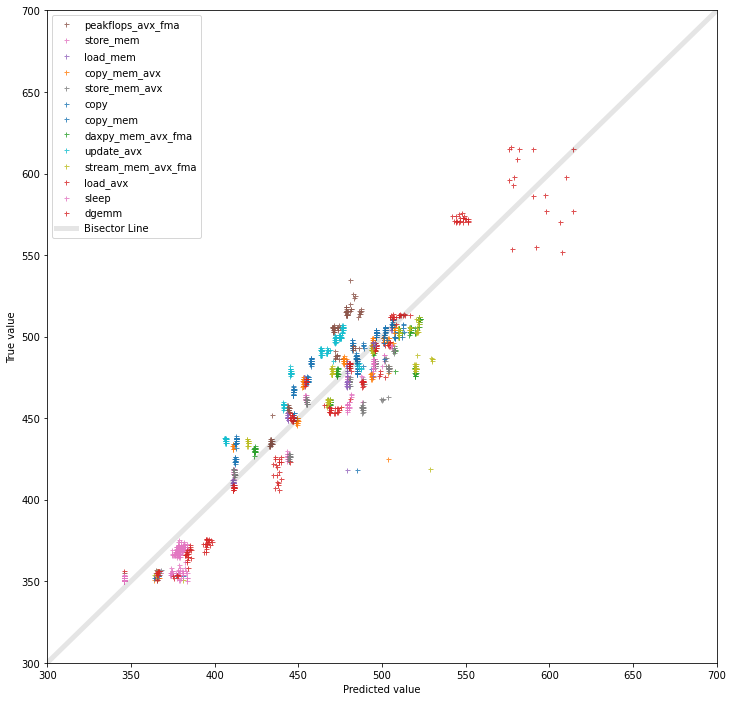

In [9]:
import warnings
warnings.filterwarnings('ignore')

df_list_test= load_df_list_test()
plt.figure(figsize=(12,12))

for df in df_list_test:
#df = pd.concat(df_list_test)
    df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
    df=df[ (df["SystemCpuUsage"] < 7) | (df["Total_power"] > 400)]

    #df1=df[ (df["SystemCpuUsage"] < 40) | (df["Total_power"] > 425)].copy()
    df1 = normalize_model1(df.copy())
    prediction=list()
    if True:
        for row in df1[independent_variables].to_numpy():
            #print(row)
            prediction.append(row@coeff_1[:-1] + intercept_1)
        df1["prediction"]=prediction
        if len(df) <1:
            continue
        test_name=df1["name"].iloc[0]
        cores=df1["cores"].iloc[0]
        plt.plot(df1["prediction"],df1["Total_power"], '+', 
                 markersize=5, 
                 alpha=0.8,
                 fillstyle='full',
                 #markeredgecolor='white',
                 markeredgewidth=1,label=test_name,color=name_to_color[test_name])

plt.plot([0,700],[0,700], '-k', linewidth=5, alpha=0.1, label='Bisector Line')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylabel("True value")
plt.xlabel("Predicted value")
plt.xlim([300,700])
plt.ylim([300,700])

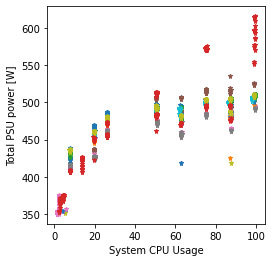

In [10]:
df_list_test= load_df_list_test()
df=pd.concat(df_list_test)
df["total_power"]=df["PSUPower0"]+df["PSUPower1"]
df=df[ (df["SystemCpuUsage"] < 7) | (df["total_power"] > 400)]

column_name_probability = ['ProbabilityScalarArithmetic',
        'ProbabilityScalarLogic',
        'ProbabilityScalarMemory',
        'ProbabilityScalarBranch',
        'ProbabilityScalarJump',
        'ProbabilityVectorArithmetic',
        'ProbabilityVectorLogic',
        'ProbabilityVectorMemory',
        'ProbabilityVectorBranch',
        'ProbabilityVectorJump']

plt.figure(figsize=(3.9,4))
color=[name_to_color[i] for i in df["name"]]

for _,row in df.iterrows():
    plt.plot(row["SystemCpuUsage"],row["total_power"],'*', markersize=5,label=row["name"], color=name_to_color[row["name"]])
    
plt.ylabel("Total PSU power [W]")
plt.xlabel("System CPU Usage")


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys())


[25, 45, 65, 85, 105, 125]


Text(0, 0.5, 'Probability')

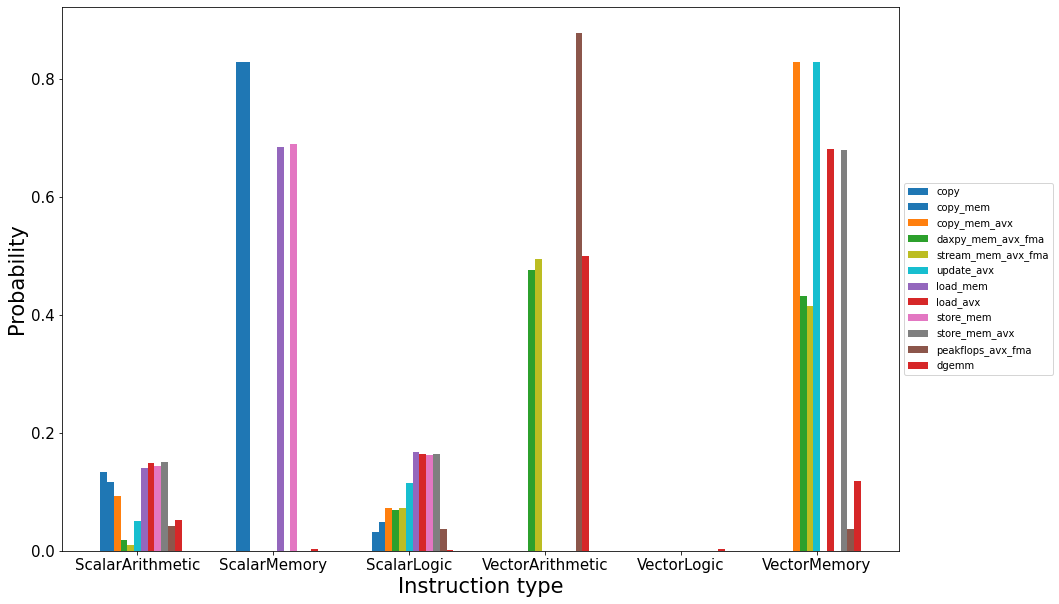

In [11]:
cores=16
independent_variables=[ "ProbabilityScalarArithmetic",
                        	"ProbabilityScalarMemory", "ProbabilityScalarLogic",
                       #"ProbabilityScalarBranch", 	"ProbabilityScalarJump",
                       "ProbabilityVectorArithmetic", 	"ProbabilityVectorLogic",
                       "ProbabilityVectorMemory", 	]#"ProbabilityVectorBranch",
                      # "ProbabilityVectorJump"]#,"SocketPower0","SocketPower1"]

column_name_probability_labels=[ "ScalarArithmetic",
                        	"ScalarMemory", "ScalarLogic",
                       #"ProbabilityScalarBranch", 	"ProbabilityScalarJump",
                       "VectorArithmetic", 	"VectorLogic",
                       "VectorMemory", 	]#"ProbabilityVectorBranch",
                      # "ProbabilityVectorJump"]#,"SocketPower0","SocketPower1"]

tests=['copy', 'copy_mem', 'copy_mem_avx', 'daxpy_mem_avx_fma', 'stream_mem_avx_fma',
 'update_avx','load_mem', 'load_avx', 'store_mem', 'store_mem_avx',
 'peakflops_avx_fma',  'dgemm']

df_list_test= load_df_list_train()
df=pd.concat(df_list_test)

jitter=np.array([i/len(tests) for i in range(0,len(tests))])
plt.figure(figsize=(15,10))
offset=0
ticks=list()
for var in independent_variables:
    y=list()
    offset+=20
    
    for test in tests:
        y.append(df[(df["cores"]==32) & (df["name"]==test)][var].mean()/100)
    plt.bar(jitter*12+offset,y,width=1.0,label=tests,color=[name_to_color[t] for t in tests])   
    ticks.append(offset+5)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

plt.legend(by_label.values(), by_label.keys(),loc='center left', bbox_to_anchor=(1, 0.5))
print(ticks)
plt.xticks(ticks=ticks, labels=column_name_probability_labels,fontsize=15,rotation=90-90)
plt.yticks(fontsize=15)
plt.xlabel("Instruction type",fontsize=21)
plt.ylabel("Probability",fontsize=21)
#for i in ticks:
#    plt.vlines(x,  colors='k', linestyles='solid')
#        print(f"{var} {test} {y}")

In [12]:
df_tmp=df[df["name"]=="dgemm"].copy()

In [13]:
df_tmp[independent_variables].mean()/100

ProbabilityScalarArithmetic    0.052839
ProbabilityScalarMemory        0.004029
ProbabilityScalarLogic         0.002649
ProbabilityVectorArithmetic    0.510796
ProbabilityVectorLogic         0.003750
ProbabilityVectorMemory        0.120059
dtype: float64

In [14]:
!pip show matplotlib


DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.


In [15]:
def normalize_model1(df):
    percentages=independent_variables=["ProbabilityScalarArithmetic",
                       "ProbabilityScalarLogic", 	"ProbabilityScalarMemory",
                       "ProbabilityScalarBranch", 	"ProbabilityScalarJump",
                       "ProbabilityVectorArithmetic", 	"ProbabilityVectorLogic",
                       "ProbabilityVectorMemory", 	"ProbabilityVectorBranch",
                       "ProbabilityVectorJump"]
    
    df[percentages]=df[percentages]/100
    Pidle = 351
    df["SystemCpuUsage"]=df["SystemCpuUsage"]*128/100
    df["ProcessCpuUsage"]=df["ProcessCpuUsage"]*128/100
    df["Total_power"]=df["PSUPower0"]+df["PSUPower1"] 
    df["Total_socket"]=df["SocketPower0"]+df["SocketPower1"] 
    TDP=280

    for var in independent_variables:
  #      df[var]=df[var]*df["SystemCpuUsage"]*TDP*2
        df[var]=np.log(df[var]*df["ProcessCpuUsage"] + 1) #*df["Total_socket"]
        
    df = df[ (df["SocketPower0"] > 0) & (df["SocketPower1"] > 0) ]
        
    return df


In [16]:
def load_df_list_train_noise():
    directory_list=["results_1500/results_no_noise"]

    #directory_list=["results_1500/results_32"]
    df_list=list()
    for directory in directory_list:
        for filename in os.listdir(directory):
            if filename.endswith(".csv"):
                try:
                    df = pd.read_csv(os.path.join(directory, filename))
                    if "no_noise" in directory:
                        bench_name="peakflops_no_noise"
                        cores=int(filename.split("_")[1].split(".")[0])
                        print(filename)
                    else:
                        bench_name="peakflops_noise"
                        cores=int(filename.split("_")[1].split(".")[0])
                    #df["name"]=directory+filename[]
                    df["name"]=bench_name
                    df["cores"]=cores
                    #df_list.append(df)
                    df_list.append(df.iloc[2:30])
                    #print(type(df_list[-1]))
                    #print(f"Opened file: {filename}")
                    #print(df.head())  # prints the first 5 rows of each CSV file
                    #plot(df,os.path.basename(filename).split(".")[0])
                except Exception as e:
                    print(e)
    return df_list
    
def load_df_list_test_noise():
    directory_list=["results_1500/results_no_noise","results_1500/results_noise"]

    #directory_list=["results_1500/results_32"]
    df_list=list()
    for directory in directory_list:
        for filename in os.listdir(directory):
            if filename.endswith(".csv"):
                try:
                    df = pd.read_csv(os.path.join(directory, filename))
                    if "no_noise" in directory:
                        bench_name="peakflops_no_noise"
                        cores=int(filename.split("_")[1].split(".")[0])
                    else:
                        bench_name="peakflops_noise"
                        cores=int(filename.split("_")[1].split(".")[0])
                    #df["name"]=directory+filename[]
                    df["name"]=bench_name
                    df["cores"]=cores
                    #df_list.append(df)
                    df_list.append(df.iloc[2:30])
                    #print(type(df_list[-1]))
                    #print(f"Opened file: {filename}")
                    #print(df.head())  # prints the first 5 rows of each CSV file
                    #plot(df,os.path.basename(filename).split(".")[0])
                except Exception as e:
                    print(e)
    return df_list
    
    

In [17]:
independent_variables=["ProbabilityScalarArithmetic",
                       "ProbabilityScalarLogic", 	"ProbabilityScalarMemory",
                       "ProbabilityScalarBranch", 	"ProbabilityScalarJump",
                       "ProbabilityVectorArithmetic", 	"ProbabilityVectorLogic",
                       "ProbabilityVectorMemory", 	"ProbabilityVectorBranch",
                       "ProbabilityVectorJump"]

df_list_train= load_df_list_train_noise()
df = pd.concat(df_list_train)
df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
df=df[ (df["SystemCpuUsage"] < 7) | (df["Total_power"] > 375)]
df = normalize_model1(df.copy())

A=df[independent_variables].to_numpy()

b=np.ones((A.shape[0],1))

A=np.hstack((A,b))

coeff_1,error_1=nnls(A, df["Total_power"].to_numpy(), maxiter=1000)
intercept_1=coeff_1[-1]
print(f"Residual {error_1}, intercept {intercept_1}")
#print(coeff)

for name,value in zip(independent_variables,coeff_1):
    print(name,value)

power_64.csv
power_16.csv
power_32.csv
power_48.csv
Residual 104.34563156754275, intercept 279.59904831621526
ProbabilityScalarArithmetic 118.72846842059383
ProbabilityScalarLogic 0.0
ProbabilityScalarMemory 0.0
ProbabilityScalarBranch 0.0
ProbabilityScalarJump 0.0
ProbabilityVectorArithmetic 20.676467113514278
ProbabilityVectorLogic 0.0
ProbabilityVectorMemory 24.84250240875031
ProbabilityVectorBranch 0.0
ProbabilityVectorJump 0.0


{'peakflops_no_noise': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), 'peakflops_noise': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0)}


(300.0, 700.0)

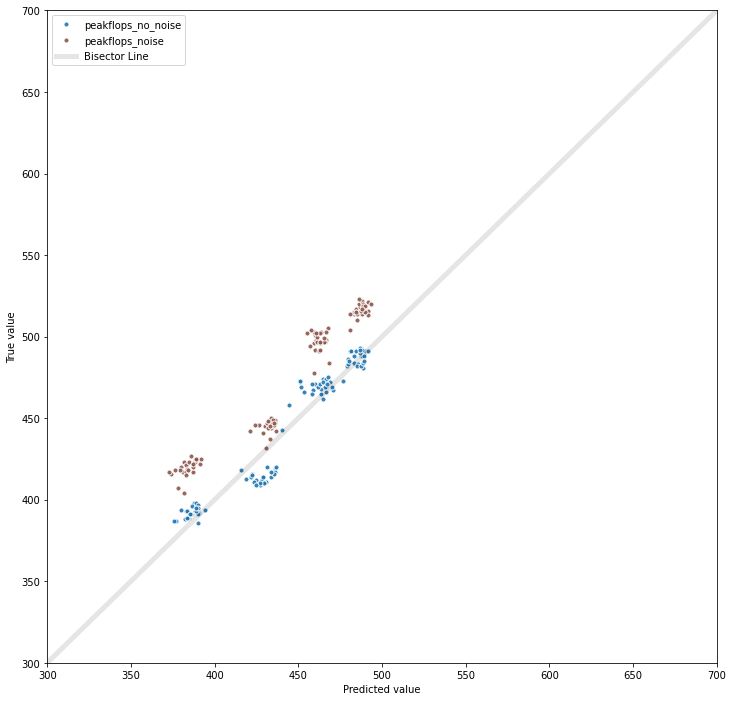

In [18]:
df= load_df_list_test_noise()
df = pd.concat(df)
# Example usage:
cores_to_color = assign_colors(df["cores"])
name_to_color = assign_colors(df["name"])

print(name_to_color)  # This will print the mapping of labels to colors
import warnings
warnings.filterwarnings('ignore')

df_list_test= load_df_list_test_noise()
plt.figure(figsize=(12,12))

for df in df_list_test:
#df = pd.concat(df_list_test)
    df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
    df=df[ (df["SystemCpuUsage"] < 7) | (df["Total_power"] > 375)]

    #df1=df[ (df["SystemCpuUsage"] < 40) | (df["Total_power"] > 425)].copy()
    df1 = normalize_model1(df.copy())
    prediction=list()
    if True:
        for row in df1[independent_variables].to_numpy():
            #print(row)
            prediction.append(row@coeff_1[:-1] + intercept_1)
        df1["prediction"]=prediction
        if len(df) <1:
            continue
        test_name=df1["name"].iloc[0]
        cores=df1["cores"].iloc[0]
        plt.plot(df1["prediction"],df1["Total_power"], 'o', 
                 markersize=5, 
                 alpha=0.9,
                 fillstyle='full',
                 markeredgecolor='white',
                 markeredgewidth=1,label=test_name,color=name_to_color[test_name])

plt.plot([0,700],[0,700], '-k', linewidth=5, alpha=0.1, label='Bisector Line')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylabel("True value")
plt.xlabel("Predicted value")
plt.xlim([300,700])
plt.ylim([300,700])

{'peakflops_no_noise': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), 'peakflops_noise': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0)}


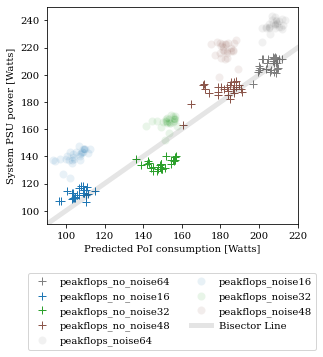

In [30]:
df= load_df_list_test_noise()
df = pd.concat(df)
# Example usage:
cores_to_color = assign_colors(df["cores"])
name_to_color = assign_colors(df["name"])

print(name_to_color)  # This will print the mapping of labels to colors
import warnings
warnings.filterwarnings('ignore')

df_list_test= load_df_list_test_noise()
plt.rcParams["font.family"] = "DeJavu Serif"
plt.figure(figsize=(4.5,4))

for df in df_list_test:
#df = pd.concat(df_list_test)
    df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
    df=df[ (df["SystemCpuUsage"] < 7) | (df["Total_power"] > 375)]

    #df1=df[ (df["SystemCpuUsage"] < 40) | (df["Total_power"] > 425)].copy()
    df1 = normalize_model1(df.copy())
    prediction=list()
    if True:
        for row in df1[independent_variables].to_numpy():
            #print(row)
            prediction.append(row@coeff_1[:-1])
        df1["prediction"]=prediction
        if len(df) <1:
            continue
        test_name=df1["name"].iloc[0]
        cores=df1["cores"].iloc[0]
        if test_name=="peakflops_no_noise":
            pass
            plt.plot(df1["prediction"],df1["Total_power"]-intercept_1, '+', 
                     markersize=8, 
                     alpha=1.0,
                     fillstyle='full',
#                     markeredgecolor='white',
                     markeredgewidth=1,label=test_name+f"{cores}",color=cores_to_color[cores])
        
        if test_name=="peakflops_noise":
            plt.plot(df1["prediction"],df1["Total_power"]-intercept_1, 'o', 
                     markersize=8, 
                     alpha=0.1,
                     fillstyle='full',
                     markeredgecolor='white',
                     markeredgewidth=1,label=test_name+f"{cores}",color=cores_to_color[cores])

plt.plot([0,700],[0,700], '-k', linewidth=5, alpha=0.1, label='Bisector Line')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(0.5, -0.6),ncol=2, loc="lower center")
plt.ylabel("System PSU power [Watts]")
plt.xlabel("Predicted PoI consumption [Watts]")
plt.xlim([90,220])
plt.ylim([90,250])
plt.savefig("power-noise.pdf", bbox_inches='tight')

Cores Median Error: 0.019721268103734882 Diff: 2.105498254887493
Cores Median Error: 0.029182477773926224 Diff: 4.350591060931777
Cores Median Error: 0.008880415073239641 Diff: 1.6346516971379401
Cores Median Error: 0.004985700188865106 Diff: 1.03339449002047


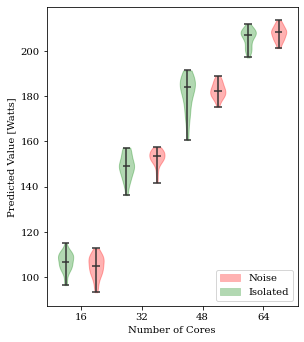

In [32]:
df= load_df_list_test_noise()
df = pd.concat(df)
# Example usage:
cores_to_color = assign_colors(df["cores"])
name_to_color = assign_colors(df["name"])

#print(name_to_color)  # This will print the mapping of labels to colors
import warnings
warnings.filterwarnings('ignore')

df_list_test= load_df_list_test_noise()
plt.rcParams["font.family"] = "DeJavu Serif"
plt.figure(figsize=(4.5,5.5))

columns=list()
columns_labels=list()
columns_dict = {}
noise_idx = []
nonoise_idx = []
idx = 0
for df in df_list_test:
    
    df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
    df=df[ (df["SystemCpuUsage"] < 10) | (df["Total_power"] > 375)]
    df1 = normalize_model1(df.copy())
    if len(df) <1:
        continue
    test_name=df1["name"].iloc[0]
    cores=df1["cores"].iloc[0]
    if cores==8:
        continue
    prediction=list()
    
    for row in df1[independent_variables].to_numpy():
        prediction.append(row@coeff_1[:-1] + intercept_1)
    df1["prediction"]=prediction-intercept_1

    test_name=df1["name"].iloc[0]
    cores=df1["cores"].iloc[0]
    
    #columns.append(df1["prediction"])
    #columns_labels.append(test_name+f"_{cores}")
    if "no_noise" in test_name:
        columns_dict[f"no_noise_{cores}"] = df1["prediction"]
    else:
        columns_dict[f"noise_{cores}"] = df1["prediction"]
        
    idx += 1
    

for i in [str(i) for i in range(16, 65, 16)]:
    nonoise = columns_dict[f"no_noise_{i}"].median()
    noise = columns_dict[f"noise_{i}"].median()
    diff = abs(noise - nonoise)
    err = diff / nonoise
    print(f"Cores Median Error: {err} Diff: {diff}")
    for j in ["no_noise", "noise"]:
        columns.append(columns_dict[f"{j}_{i}"])
        columns_labels.append(f"{i}")
        
#print(columns_dict.keys())
#columns_labels=['No-Noise 16 cores', 'No-Noise 32 cores', 'No-Noise 48 cores', 'No-Noise 64 cores', 'Noise 32 cores', 'Noise 48 cores', 'Noise 64 cores', 'Noise 16 cores']

#columns,columns_labels=swap(columns,columns_labels,1,-1)
#columns,columns_labels=swap(columns,columns_labels,2,-1)
#columns,columns_labels=swap(columns,columns_labels,3,4)
#columns,columns_labels=swap(columns,columns_labels,-1,4)


#columns[2],columns[4]=columns[4],columns[2]
#columns_labels[2],columns_labels[4]=columns_labels[4],columns_labels[2]

violin_parts = plt.violinplot(columns, showmedians=True)
plt.xticks([y + 1 for y in range(len(columns))],
                  labels=columns_labels,rotation=90-15)

colors = ['Green','Red', 'Green','Red', 'Green','Red', 'Green', 'Red']
# Set the color of the violin patches
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_edgecolor(color)

#print(dir(violin_parts["cmedians"]))
for key in ['cmaxes', 'cmins', 'cbars', 'cmedians']:
    violin_parts[key].set_color("#333333")
    
#plt.plot([0,700],[0,700], '-k', linewidth=5, alpha=0.1, label='Bisector Line')
#handles, labels = plt.gca().get_legend_handles_labels()
#by_label = dict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys())
plt.ylabel("Predicted Value [Watts]")
#plt.xlabel("experiment")
#print(ticks)
plt.xticks(ticks=[1.5,3.5,5.5,7.5], labels=["16","32","48","64",],rotation=90-90)
plt.xlabel("Number of Cores")

red_patch = mpatches.Patch(color='#ffb2b2', label='Noise')
blue_patch = mpatches.Patch(color='#b2d8b2', label='Isolated')

plt.legend(handles=[red_patch, blue_patch], loc="lower right")
plt.savefig("violin.pdf", bbox_inches='tight')

#plt.xlim([300,700])
#plt.ylim([300,700])

In [21]:
def load_df_noise():
    directory_list=["results_1500/results_noise"]

    #directory_list=["results_1500/results_32"]
    df_list=list()
    for directory in directory_list:
        for filename in os.listdir(directory):
            if filename.endswith(".csv"):
                try:
                    df = pd.read_csv(os.path.join(directory, filename))
                    if "no_noise" in directory:
                        bench_name="peakflops_no_noise"
                        cores=int(filename.split("_")[1].split(".")[0])
                    else:
                        bench_name="peakflops_noise"
                        cores=int(filename.split("_")[1].split(".")[0])
                    #df["name"]=directory+filename[]
                    df["name"]=bench_name
                    df["cores"]=cores
                    #df_list.append(df)
                    df_list.append(df.iloc[2:20])
                    #print(type(df_list[-1]))
                    #print(f"Opened file: {filename}")
                    #print(df.head())  # prints the first 5 rows of each CSV file
                    #plot(df,os.path.basename(filename).split(".")[0])
                except Exception as e:
                    print(e)
    return df_list
    
def load_df_no_noise():
    directory_list=["results_1500/results_no_noise"]

    #directory_list=["results_1500/results_32"]
    df_list=list()
    for directory in directory_list:
        for filename in os.listdir(directory):
            if filename.endswith(".csv"):
                try:
                    df = pd.read_csv(os.path.join(directory, filename))
                    if "no_noise" in directory:
                        bench_name="peakflops_no_noise"
                        cores=int(filename.split("_")[1].split(".")[0])
                    else:
                        bench_name="peakflops_noise"
                        cores=int(filename.split("_")[1].split(".")[0])
                    #df["name"]=directory+filename[]
                    df["name"]=bench_name
                    df["cores"]=cores
                    #df_list.append(df)
                    df_list.append(df.iloc[2:20])
                    #print(type(df_list[-1]))
                    #print(f"Opened file: {filename}")
                    #print(df.head())  # prints the first 5 rows of each CSV file
                    #plot(df,os.path.basename(filename).split(".")[0])
                except Exception as e:
                    print(e)
    return df_list

In [22]:
Pstatic=345.9


In [23]:
Cores=64
df=pd.concat(load_df_noise())
df=df[df["cores"]==Cores]
df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
dynnoise = df['Total_power'].mean()-Pstatic
print(f"E[total-static] {dynnoise}")
df=pd.concat(load_df_no_noise())
df=df[df["cores"]==Cores]
df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
dynnonoise = df['Total_power'].mean()-Pstatic
print(f"E[total-static] {dynnonoise}")
print(f"Difference: {dynnoise - dynnonoise}")

E[total-static] 170.10000000000002
E[total-static] 139.7111111111111
Difference: 30.388888888888914
